## Homework №3

### Neural Machine Translation in the wild
In the third homework you are supposed to get the best translation you can for the EN-RU translation task.

Basic approach using RNNs as encoder and decoder is implemented for you. 

Your ultimate task is to use the techniques we've covered, e.g.

* Optimization enhancements (e.g. learning rate decay)

* CNN encoder (with or without positional encoding)

* attention/self-attention mechanism

* pretraining the language model

* [Byte Pair Encoding](https://github.com/rsennrich/subword-nmt)

* or just fine-tunning BERT ;)

to improve the translation quality. 

__Please use at least three different approaches/models and compare them (translation quality/complexity/training and evaluation time).__

Write down some summary on your experiments and illustrate it with convergence plots/metrics and your thoughts. Just like you would approach a real problem.

In [1]:
from datetime import datetime

DEVICE_NAME = 'cuda:1'

now = datetime.now().strftime("%Y-%m-%d--%H-%M-%S")
model_name = f'gru_attention_dynamic_teacher_forcing_{now}'

In [2]:
# Thanks to YSDA NLP course team for the data
# (who thanks tilda and deephack teams for the data in their turn)

import os
path_to_data = '../../datasets/Machine_translation_EN_RU/data.txt'
if not os.path.exists(path_to_data):
    print("Dataset not found locally. Downloading from github.")
    !wget https://raw.githubusercontent.com/neychev/made_nlp_course/master/datasets/Machine_translation_EN_RU/data.txt -nc
    path_to_data = './data.txt'

In [3]:
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.tensorboard import SummaryWriter

import torchtext
from torchtext.data import Field, BucketIterator
from nltk.tokenize import WordPunctTokenizer
from nltk.translate.bleu_score import corpus_bleu

from tqdm import tqdm
import time
import random

import matplotlib.pyplot as plt
%matplotlib inline

from utils import generate_translation, remove_tech_tokens, get_text, parse_tensorboard_logs, plot_metrics

In [4]:
SEED = 1234

random.seed(SEED)
torch.manual_seed(SEED)
torch.cuda.manual_seed_all(SEED)
torch.backends.cudnn.deterministic = True
torch.backends.cudnn.benchmark = False

### Main part
__Here comes the preprocessing. Do not hesitate to use BPE or more complex preprocessing ;)__

In [5]:
tokenizer_W = WordPunctTokenizer()
def tokenize(x, tokenizer=tokenizer_W):
    return tokenizer.tokenize(x.lower())

In [6]:
SRC = Field(tokenize=tokenize,
            init_token = '<sos>', 
            eos_token = '<eos>', 
            lower = True)

TRG = Field(tokenize=tokenize,
            init_token = '<sos>', 
            eos_token = '<eos>', 
            lower = True)

dataset = torchtext.data.TabularDataset(
    path=path_to_data,
    format='tsv',
    fields=[('trg', TRG), ('src', SRC)]
)

In [7]:
train_data, valid_data, test_data = dataset.split(split_ratio=[0.8, 0.15, 0.05], random_state=random.seed(SEED))

In [8]:
print(f"Number of training examples: {len(train_data.examples)}")
print(f"Number of validation examples: {len(valid_data.examples)}")
print(f"Number of testing examples: {len(test_data.examples)}")

Number of training examples: 40000
Number of validation examples: 2500
Number of testing examples: 7500


In [9]:
SRC.build_vocab(train_data, min_freq=3)
TRG.build_vocab(train_data, min_freq=3)

In [10]:
print(f"Unique tokens in source (ru) vocabulary: {len(SRC.vocab)}")
print(f"Unique tokens in target (en) vocabulary: {len(TRG.vocab)}")

Unique tokens in source (ru) vocabulary: 9256
Unique tokens in target (en) vocabulary: 6734


Here are tokens from original (RU) corpus:

In [11]:
SRC.vocab.itos[::1000]

['<unk>',
 'террасу',
 'чистые',
 'компьютеры',
 'don',
 'шамони',
 'logis',
 'форму',
 'душевые',
 'техасского']

And from target (EN) corpus:

In [12]:
TRG.vocab.itos[::1000]

['<unk>', 'springs', 'galeao', 'calm', 'occupies', 'tegel', 'malioboro']

And here is example from train dataset:

In [13]:
idx = 9
print(' '.join(train_data.examples[idx].src))
print(' '.join(train_data.examples[idx].trg))

также предлагается доставка продуктов , услуги прачечной и гладильные услуги .
other facilities offered at the property include grocery deliveries , laundry and ironing services .


Let's check the length distributions:

Length distribution in Train data
Max source length: 73
Max target length: 89


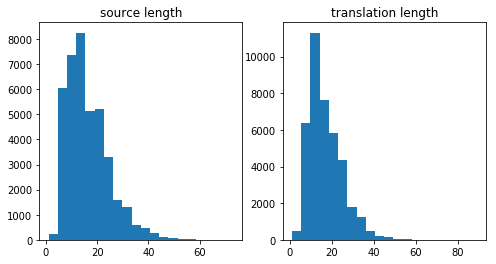

In [14]:
src_length = list(map(len, [x.src for x in train_data.examples]))
trg_length = list(map(len, [x.trg for x in train_data.examples]))

print('Length distribution in Train data')
print(f'Max source length: {max(src_length)}')
print(f'Max target length: {max(trg_length)}')
plt.figure(figsize=[8, 4])
plt.subplot(1, 2, 1)
plt.title("source length")
plt.hist(list(src_length), bins=20);

plt.subplot(1, 2, 2)
plt.title("translation length")
plt.hist(list(trg_length), bins=20);

Length distribution in Test data
Max source length: 80
Max target length: 99


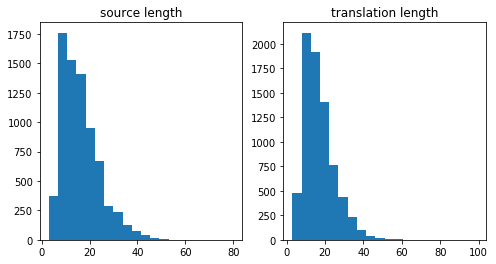

In [15]:
src_length = list(map(len, [x.src for x in test_data.examples]))
trg_length = list(map(len, [x.trg for x in test_data.examples]))

print('Length distribution in Test data')
print(f'Max source length: {max(src_length)}')
print(f'Max target length: {max(trg_length)}')
plt.figure(figsize=[8, 4])
plt.subplot(1, 2, 1)
plt.title("source length")
plt.hist(list(src_length), bins=20);

plt.subplot(1, 2, 2)
plt.title("translation length")
plt.hist(list(trg_length), bins=20);

### Model side
__Here comes simple pipeline of NMT model learning. It almost copies the week03 practice__

In [16]:
device = torch.device(DEVICE_NAME if torch.cuda.is_available() else 'cpu')
device

device(type='cuda', index=1)

In [17]:
def _len_sort_key(x):
    return len(x.src)

In [18]:
def init_weights(m):
    for name, param in m.named_parameters():
        nn.init.uniform_(param, -0.08, 0.08)

In [19]:
def count_parameters(model):
    return sum(p.numel() for p in model.parameters() if p.requires_grad)

In [20]:
PAD_IDX = TRG.vocab.stoi['<pad>']

In [21]:
def eval_bleu(model, test_iterator, target_vocab=TRG.vocab, with_tqdm=True):
    original_text = []
    generated_text = []
    model.eval()
    with torch.no_grad():
        test_iterator = tqdm(enumerate(test_iterator)) if with_tqdm else enumerate(test_iterator)
        for i, batch in test_iterator:
            src = batch.src # [src sent len, batch size]
            trg = batch.trg # [trg sent len, batch size]

            output = model(src, trg, 0) #turn off teacher forcing
            #output = [trg sent len, batch size, output dim]

            output = output.argmax(dim=-1)

            original_text.extend([get_text(x, target_vocab) for x in trg.cpu().numpy().T])
            generated_text.extend([get_text(x, target_vocab) for x in output[1:].detach().cpu().numpy().T])
    return corpus_bleu([[text] for text in original_text], generated_text) * 100

In [22]:
def get_teacher_forcing_ratio(epoch, base_teacher_forcing_ratio=0.5, decay=0.7):
    return base_teacher_forcing_ratio * decay ** epoch

In [23]:
def train(model, iterator, optimizer, criterion, clip, epoch):
    model.train()
    epoch_loss = 0
    for i, batch in enumerate(iterator):        
        src = batch.src # [src sent len, batch size]
        trg = batch.trg # [trg sent len, batch size]
        
        optimizer.zero_grad()        
        teacher_forcing_ratio = get_teacher_forcing_ratio(epoch)
        output = model(src, trg, teacher_forcing_ratio) # [trg sent len, batch size, output dim]
        
        output = output[1:].view(-1, output.shape[-1]) # [(trg sent len - 1) * batch size, output dim]
        trg = trg[1:].view(-1) # [(trg sent len - 1) * batch size]
        
        loss = criterion(output, trg)        
        loss.backward()
        
        # Let's clip the gradient
        nn.utils.clip_grad_norm_(model.parameters(), clip)
        
        optimizer.step()        
        batch_loss = loss.item()
        epoch_loss += batch_loss
        
    return epoch_loss / len(iterator)

In [24]:
def evaluate(model, iterator, criterion):    
    model.eval()    
    epoch_loss = 0    
    with torch.no_grad():    
        for i, batch in enumerate(iterator):
            src = batch.src # [src sent len, batch size]
            trg = batch.trg # [trg sent len, batch size]

            output = model(src, trg, 0) #turn off teacher forcing
            # [trg sent len, batch size, output dim]

            output = output[1:].view(-1, output.shape[-1]) # [(trg sent len - 1) * batch size]
            trg = trg[1:].view(-1) # [(trg sent len - 1) * batch size, output dim]

            loss = criterion(output, trg)            
            epoch_loss += loss.item()
        
    return epoch_loss / len(iterator)

In [25]:
def epoch_time(start_time, end_time):
    elapsed_time = end_time - start_time
    elapsed_mins = int(elapsed_time / 60)
    elapsed_secs = int(elapsed_time - (elapsed_mins * 60))
    return elapsed_mins, elapsed_secs

In [26]:
def training_procedure(model, model_name, train_iterator, valid_iterator,
                      optimizer, lr_scheduler, criterion, writer, clip, n_epochs):
    best_valid_bleu = float('-inf')
    for epoch in tqdm(range(n_epochs)):    
        start_time = time.time()

        train_loss = train(model, train_iterator, optimizer, criterion, clip, epoch)
        valid_loss = evaluate(model, valid_iterator, criterion)
        lr_scheduler.step(valid_loss)

        end_time = time.time()
        epoch_mins, epoch_secs = epoch_time(start_time, end_time)
        
        valid_bleu = eval_bleu(model, valid_iterator, with_tqdm=False)
        if valid_bleu > best_valid_bleu:
            best_valid_bleu = valid_bleu
            torch.save(model.state_dict(), f'models/{model_name}.pt')

        writer.add_scalar('Train loss',
                    train_loss,
                    epoch)
        writer.add_scalar('Validation loss',
                    valid_loss,
                    epoch)
        writer.add_scalar('Validation BLEU',
                    valid_bleu,
                    epoch)
        print(f'Epoch: {epoch+1:02} | Time: {epoch_mins}m {epoch_secs}s')
        print(f'\tTrain Loss: {train_loss:.3f} | Train PPL: {np.exp(train_loss):7.3f}')
        print(f'\t Val. Loss: {valid_loss:.3f} |  Val. PPL: {np.exp(valid_loss):7.3f} |  Val. BLEU: {valid_bleu:.3f}')

In [27]:
def get_tensorboard_dir(model_name):
    return f'runs/{model_name}'

In [28]:
def print_samples(model, test_iterator, indices=range(1, 3)):
    batch = next(iter(test_iterator))
    for idx in indices:
        src = batch.src[:, idx:idx+1]
        trg = batch.trg[:, idx:idx+1]
        generate_translation(src, trg, model, TRG.vocab)

## Let's add attention to baseline

In [29]:
BATCH_SIZE = 128

train_iterator, valid_iterator, test_iterator = BucketIterator.splits(
    (train_data, valid_data, test_data), 
    batch_size = BATCH_SIZE, 
    device = device,
    sort_key=_len_sort_key
)

In [30]:
class GruEncoder(nn.Module):
    def __init__(self, input_dim, emb_dim, hid_dim, n_layers, dropout):
        super().__init__()
        
        self.input_dim = input_dim
        self.emb_dim = emb_dim
        self.hid_dim = hid_dim
        self.n_layers = n_layers
        
        self.embedding = nn.Embedding(
            num_embeddings=input_dim,
            embedding_dim=emb_dim
        )
        
        self.rnn = nn.GRU(
            input_size=emb_dim,
            hidden_size=hid_dim,
            num_layers=n_layers,
            dropout=dropout
        )
        
        self.dropout = nn.Dropout(p=dropout)
        
    def forward(self, src, hidden=None):        
        # src = [src sent len, batch size]        
        embedded = self.embedding(src) # [src sent len, batch size, emb dim]
        embedded = self.dropout(embedded)
        
        if hidden is None:
            output, hidden = self.rnn(embedded)
        else:
            output, hidden = self.rnn(embedded, hidden)
        
        # output = [src sent len, batch size, hid dim * n directions]
        # hidden = [n layers * n directions, batch size, hid dim]
        
        return hidden

In [31]:
from torchnlp.nn.attention import Attention

class AttentionGruDecoder(nn.Module):
    def __init__(self, output_dim, emb_dim, hid_dim, n_layers, dropout):
        super().__init__()

        self.emb_dim = emb_dim
        self.hid_dim = hid_dim
        self.output_dim = output_dim
        self.n_layers = n_layers
        
        self.embedding = nn.Embedding(
            num_embeddings=output_dim,
            embedding_dim=emb_dim
        )
        
        self.attention = Attention(dimensions=n_layers*hid_dim, attention_type='general')
        
        self.rnn = nn.GRU(
            input_size=emb_dim,
            hidden_size=hid_dim,
            num_layers=n_layers,
            dropout=dropout
        )
        
        self.out = nn.Linear(
            in_features=n_layers*hid_dim,
            out_features=output_dim
        )
        
        self.dropout = nn.Dropout(p=dropout)
        
    def forward(self, input, hidden, encoder_outputs):        
        # input = [batch size]
        # hidden = [n layers * n directions, batch size, hid dim]
        # encoder_outputs = [batch size, src sent len, dimensions = n layers * hid dim]
        
        batch_size = input.shape[0]        
        input = input.unsqueeze(0) # [1, batch size]
        
        embedded = self.dropout(self.embedding(input)) # [1, batch size, emb dim]
        
        output, hidden = self.rnn(embedded, hidden)
        # output = [sent len, batch size, hid dim * n directions]
        # hidden = [n layers * n directions, batch size, hid dim]
        
        # [batch size, output length = 1, dimensions = n layers * n directions * hid dim]
        query = hidden.permute(1, 0, 2).reshape(batch_size, 1, self.n_layers * self.hid_dim)
        
        # [batch size, output length = 1, dimensions = n layers * hid dim]
        attention_output, _ = self.attention(query, encoder_outputs)
        
        # [batch size, dimensions = n layers * hid dim]
        attention_output = attention_output.squeeze(1)
        
        # [batch size, output dim]
        prediction = self.out(attention_output)
        
        return prediction, hidden

In [32]:
class AttentionGruSeq2Seq(nn.Module):
    def __init__(self, encoder, decoder, device):
        super().__init__()
        
        self.encoder = encoder
        self.decoder = decoder
        self.device = device
        
        assert encoder.hid_dim == decoder.hid_dim, \
            "Hidden dimensions of encoder and decoder must be equal!"
        assert encoder.n_layers == decoder.n_layers, \
            "Encoder and decoder must have equal number of layers!"
        
    def forward(self, src, trg, teacher_forcing_ratio=0.5):        
        # src = [src sent len, batch size]
        # trg = [trg sent len, batch size]
        # teacher_forcing_ratio is probability to use teacher forcing
        # e.g. if teacher_forcing_ratio is 0.75 we use ground-truth inputs 75% of the time
        
        batch_size = trg.shape[1]
        max_len = trg.shape[0]
        trg_vocab_size = self.decoder.output_dim
        
        decoder_outputs = torch.zeros(max_len, batch_size, trg_vocab_size).to(self.device)
        
        encoder_state_size = self.encoder.n_layers * self.encoder.hid_dim
        
        # [src sent len, batch size, dimensions = n layers * hid dim]
        encoder_states = torch.zeros(src.shape[0], batch_size, encoder_state_size).to(self.device)
        
        first_encoder_input = src[0].unsqueeze(0) # [1, batch size]
        hidden = self.encoder(first_encoder_input) # [n layers * n directions, batch size, hid dim]
        # [batch size, n layers * n directions * hid dim]
        encoder_states[0] = hidden.permute(1,0,2).reshape(batch_size, encoder_state_size)
        
        for t in range(1, src.shape[0]):
            hidden = self.encoder(src[t].unsqueeze(0), hidden)
            encoder_states[t] = hidden.permute(1,0,2).reshape(batch_size, encoder_state_size)
        
        # [batch size, src sent len, dimensions = n layers * hid dim]
        encoder_states = encoder_states.permute(1, 0, 2)
        
        # first input to the decoder is the <sos> tokens
        input = trg[0,:]
        
        for t in range(1, max_len):            
            output, hidden = self.decoder(input, hidden, encoder_states)
            decoder_outputs[t] = output
            teacher_force = random.random() < teacher_forcing_ratio
            top1 = output.max(1)[1]
            input = (trg[t] if teacher_force else top1)
        
        return decoder_outputs

In [33]:
INPUT_DIM = len(SRC.vocab)
OUTPUT_DIM = len(TRG.vocab)
ENC_EMB_DIM = 256
DEC_EMB_DIM = 256
HID_DIM = 512
N_LAYERS = 2
ENC_DROPOUT = 0.5
DEC_DROPOUT = 0.5

LR = 1e-3
CLIP = 1
N_EPOCHS = 30

In [34]:
enc = GruEncoder(INPUT_DIM, ENC_EMB_DIM, HID_DIM, N_LAYERS, ENC_DROPOUT)
dec = AttentionGruDecoder(OUTPUT_DIM, DEC_EMB_DIM, HID_DIM, N_LAYERS, DEC_DROPOUT)
model = AttentionGruSeq2Seq(enc, dec, device).to(device)
model.apply(init_weights)

AttentionGruSeq2Seq(
  (encoder): GruEncoder(
    (embedding): Embedding(9256, 256)
    (rnn): GRU(256, 512, num_layers=2, dropout=0.5)
    (dropout): Dropout(p=0.5, inplace=False)
  )
  (decoder): AttentionGruDecoder(
    (embedding): Embedding(6734, 256)
    (attention): Attention(
      (linear_in): Linear(in_features=1024, out_features=1024, bias=False)
      (linear_out): Linear(in_features=2048, out_features=1024, bias=False)
      (softmax): Softmax(dim=-1)
      (tanh): Tanh()
    )
    (rnn): GRU(256, 512, num_layers=2, dropout=0.5)
    (out): Linear(in_features=1024, out_features=6734, bias=True)
    (dropout): Dropout(p=0.5, inplace=False)
  )
)

In [35]:
count_parameters(model)

19658830

In [36]:
optimizer = optim.AdamW(model.parameters(), lr=LR, weight_decay=0.001, amsgrad=True)
lr_scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, 'min', factor=0.3, patience=2)
criterion = nn.CrossEntropyLoss(ignore_index=PAD_IDX)

In [37]:
tensorboard_dir = get_tensorboard_dir(model_name)
print(tensorboard_dir)
writer = SummaryWriter(tensorboard_dir)
training_procedure(model, model_name, train_iterator, valid_iterator,
                      optimizer, lr_scheduler, criterion, writer, clip=CLIP, n_epochs=N_EPOCHS)

  0%|          | 0/30 [00:00<?, ?it/s]

runs/gru_attention_dynamic_teacher_forcing_2020-05-26--23-50-53


  3%|▎         | 1/30 [02:13<1:04:23, 133.22s/it]

Epoch: 01 | Time: 2m 10s
	Train Loss: 4.209 | Train PPL:  67.322
	 Val. Loss: 4.706 |  Val. PPL: 110.616 |  Val. BLEU: 17.175


  7%|▋         | 2/30 [04:27<1:02:16, 133.46s/it]

Epoch: 02 | Time: 2m 10s
	Train Loss: 3.500 | Train PPL:  33.121
	 Val. Loss: 4.204 |  Val. PPL:  66.951 |  Val. BLEU: 22.808


 10%|█         | 3/30 [06:41<1:00:08, 133.65s/it]

Epoch: 03 | Time: 2m 11s
	Train Loss: 3.442 | Train PPL:  31.239
	 Val. Loss: 3.708 |  Val. PPL:  40.768 |  Val. BLEU: 20.599


 13%|█▎        | 4/30 [08:54<57:53, 133.59s/it]  

Epoch: 04 | Time: 2m 11s
	Train Loss: 3.396 | Train PPL:  29.836
	 Val. Loss: 3.746 |  Val. PPL:  42.336 |  Val. BLEU: 22.522


 17%|█▋        | 5/30 [11:08<55:41, 133.65s/it]

Epoch: 05 | Time: 2m 11s
	Train Loss: 3.321 | Train PPL:  27.691
	 Val. Loss: 3.592 |  Val. PPL:  36.298 |  Val. BLEU: 20.804


 20%|██        | 6/30 [13:22<53:26, 133.60s/it]

Epoch: 06 | Time: 2m 11s
	Train Loss: 3.235 | Train PPL:  25.413
	 Val. Loss: 3.541 |  Val. PPL:  34.513 |  Val. BLEU: 15.938


 23%|██▎       | 7/30 [15:32<50:53, 132.76s/it]

Epoch: 07 | Time: 2m 8s
	Train Loss: 3.147 | Train PPL:  23.271
	 Val. Loss: 3.597 |  Val. PPL:  36.487 |  Val. BLEU: 16.016


 27%|██▋       | 8/30 [17:44<48:35, 132.53s/it]

Epoch: 08 | Time: 2m 9s
	Train Loss: 3.055 | Train PPL:  21.216
	 Val. Loss: 3.661 |  Val. PPL:  38.889 |  Val. BLEU: 15.932


 30%|███       | 9/30 [19:58<46:28, 132.78s/it]

Epoch: 09 | Time: 2m 11s
	Train Loss: 2.975 | Train PPL:  19.589
	 Val. Loss: 3.642 |  Val. PPL:  38.176 |  Val. BLEU: 14.841


 33%|███▎      | 10/30 [22:10<44:14, 132.73s/it]

Epoch: 10 | Time: 2m 10s
	Train Loss: 2.726 | Train PPL:  15.274
	 Val. Loss: 3.586 |  Val. PPL:  36.084 |  Val. BLEU: 17.448


 37%|███▋      | 11/30 [24:24<42:09, 133.15s/it]

Epoch: 11 | Time: 2m 12s
	Train Loss: 2.630 | Train PPL:  13.874
	 Val. Loss: 3.622 |  Val. PPL:  37.414 |  Val. BLEU: 17.335


 40%|████      | 12/30 [26:37<39:53, 132.98s/it]

Epoch: 12 | Time: 2m 10s
	Train Loss: 2.584 | Train PPL:  13.245
	 Val. Loss: 3.634 |  Val. PPL:  37.850 |  Val. BLEU: 16.973


 43%|████▎     | 13/30 [28:48<37:30, 132.38s/it]

Epoch: 13 | Time: 2m 8s
	Train Loss: 2.493 | Train PPL:  12.092
	 Val. Loss: 3.634 |  Val. PPL:  37.882 |  Val. BLEU: 17.526


 47%|████▋     | 14/30 [31:00<35:17, 132.36s/it]

Epoch: 14 | Time: 2m 10s
	Train Loss: 2.464 | Train PPL:  11.749
	 Val. Loss: 3.656 |  Val. PPL:  38.695 |  Val. BLEU: 17.499


 50%|█████     | 15/30 [33:12<33:03, 132.27s/it]

Epoch: 15 | Time: 2m 9s
	Train Loss: 2.447 | Train PPL:  11.552
	 Val. Loss: 3.653 |  Val. PPL:  38.577 |  Val. BLEU: 17.360


 53%|█████▎    | 16/30 [35:24<30:51, 132.22s/it]

Epoch: 16 | Time: 2m 10s
	Train Loss: 2.414 | Train PPL:  11.178
	 Val. Loss: 3.662 |  Val. PPL:  38.939 |  Val. BLEU: 17.672


 57%|█████▋    | 17/30 [37:38<28:42, 132.47s/it]

Epoch: 17 | Time: 2m 10s
	Train Loss: 2.406 | Train PPL:  11.094
	 Val. Loss: 3.658 |  Val. PPL:  38.774 |  Val. BLEU: 17.586


 60%|██████    | 18/30 [39:50<26:29, 132.49s/it]

Epoch: 18 | Time: 2m 10s
	Train Loss: 2.401 | Train PPL:  11.036
	 Val. Loss: 3.669 |  Val. PPL:  39.199 |  Val. BLEU: 17.692


 63%|██████▎   | 19/30 [42:03<24:19, 132.69s/it]

Epoch: 19 | Time: 2m 11s
	Train Loss: 2.392 | Train PPL:  10.937
	 Val. Loss: 3.666 |  Val. PPL:  39.113 |  Val. BLEU: 17.654


 67%|██████▋   | 20/30 [44:17<22:09, 132.98s/it]

Epoch: 20 | Time: 2m 11s
	Train Loss: 2.389 | Train PPL:  10.901
	 Val. Loss: 3.666 |  Val. PPL:  39.113 |  Val. BLEU: 17.651


 70%|███████   | 21/30 [46:32<20:03, 133.72s/it]

Epoch: 21 | Time: 2m 13s
	Train Loss: 2.388 | Train PPL:  10.895
	 Val. Loss: 3.669 |  Val. PPL:  39.195 |  Val. BLEU: 17.727


 73%|███████▎  | 22/30 [48:45<17:48, 133.51s/it]

Epoch: 22 | Time: 2m 10s
	Train Loss: 2.384 | Train PPL:  10.849
	 Val. Loss: 3.668 |  Val. PPL:  39.188 |  Val. BLEU: 17.747


 77%|███████▋  | 23/30 [50:58<15:31, 133.11s/it]

Epoch: 23 | Time: 2m 10s
	Train Loss: 2.385 | Train PPL:  10.862
	 Val. Loss: 3.668 |  Val. PPL:  39.168 |  Val. BLEU: 17.734


 80%|████████  | 24/30 [53:11<13:20, 133.36s/it]

Epoch: 24 | Time: 2m 11s
	Train Loss: 2.385 | Train PPL:  10.855
	 Val. Loss: 3.668 |  Val. PPL:  39.185 |  Val. BLEU: 17.650


 83%|████████▎ | 25/30 [55:23<11:03, 132.77s/it]

Epoch: 25 | Time: 2m 9s
	Train Loss: 2.382 | Train PPL:  10.830
	 Val. Loss: 3.669 |  Val. PPL:  39.199 |  Val. BLEU: 17.687


 87%|████████▋ | 26/30 [57:33<08:48, 132.07s/it]

Epoch: 26 | Time: 2m 8s
	Train Loss: 2.384 | Train PPL:  10.847
	 Val. Loss: 3.670 |  Val. PPL:  39.233 |  Val. BLEU: 17.672


 90%|█████████ | 27/30 [59:45<06:36, 132.00s/it]

Epoch: 27 | Time: 2m 9s
	Train Loss: 2.382 | Train PPL:  10.824
	 Val. Loss: 3.670 |  Val. PPL:  39.240 |  Val. BLEU: 17.655


 93%|█████████▎| 28/30 [1:01:58<04:24, 132.37s/it]

Epoch: 28 | Time: 2m 11s
	Train Loss: 2.382 | Train PPL:  10.823
	 Val. Loss: 3.670 |  Val. PPL:  39.234 |  Val. BLEU: 17.653


 97%|█████████▋| 29/30 [1:04:10<02:12, 132.09s/it]

Epoch: 29 | Time: 2m 9s
	Train Loss: 2.382 | Train PPL:  10.825
	 Val. Loss: 3.669 |  Val. PPL:  39.225 |  Val. BLEU: 17.635


100%|██████████| 30/30 [1:06:24<00:00, 132.66s/it]

Epoch: 30 | Time: 2m 11s
	Train Loss: 2.380 | Train PPL:  10.810
	 Val. Loss: 3.670 |  Val. PPL:  39.235 |  Val. BLEU: 17.628


**Let's load best model**

In [38]:
with open(f'models/{model_name}.pt', 'rb') as fp:
    best_state_dict = torch.load(fp, map_location='cpu')
    model.load_state_dict(best_state_dict)

**And look at its predictions**

In [39]:
print_samples(model, test_iterator, range(10))

Original: there is a 24 - hour front desk at the property .
Generated: you will find a 24 - hour front desk at the property .

Original: you will find a 24 - hour front desk at the property .
Generated: you will find a 24 - hour front desk at the property .

Original: there is a 24 - hour front desk at the property .
Generated: you will find a 24 - hour front desk at the property .

Original: free private parking is available .
Generated: private parking is available on site .

Original: there are several restaurants in the surrounding area .
Generated: several restaurants are nearby restaurants nearby .

Original: the property also offers free parking .
Generated: free parking is available .

Original: the unit is fitted with a kitchen .
Generated: the kitchen is a kitchen .

Original: the bathroom has a shower .
Generated: the bathroom comes with a shower .

Original: there is also a fireplace in the living room .
Generated: the living room with a fireplace .

Original: you will find

In [40]:
print('Test BLEU:', eval_bleu(model, test_iterator))

59it [00:04,  5.99it/s]


Test BLEU: 22.209852929657274


**And plot train/val metrics**

In [41]:
logs = parse_tensorboard_logs(tensorboard_dir)

In [42]:
printable_model_name = '_'.join(model_name.split('_')[:-1])

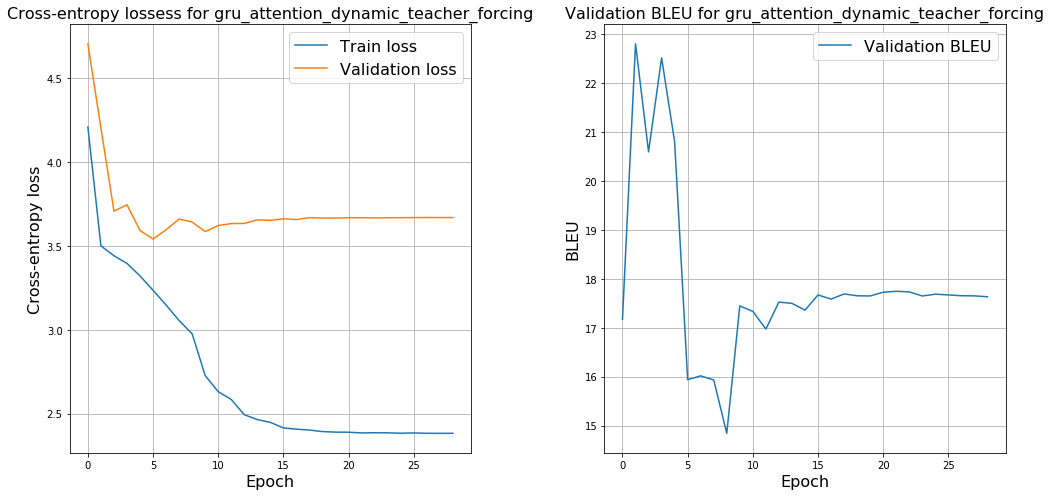

In [50]:
plot_metrics(logs, printable_model_name)